In [1]:
!pip install astra-toolbox

from PIL import Image
from sklearn.metrics import jaccard_score

import astra
import numpy as np
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

e1, e2, dice, jaccard: 0 0.37665915351865764 0.7932361836667676 0.6573251310093415


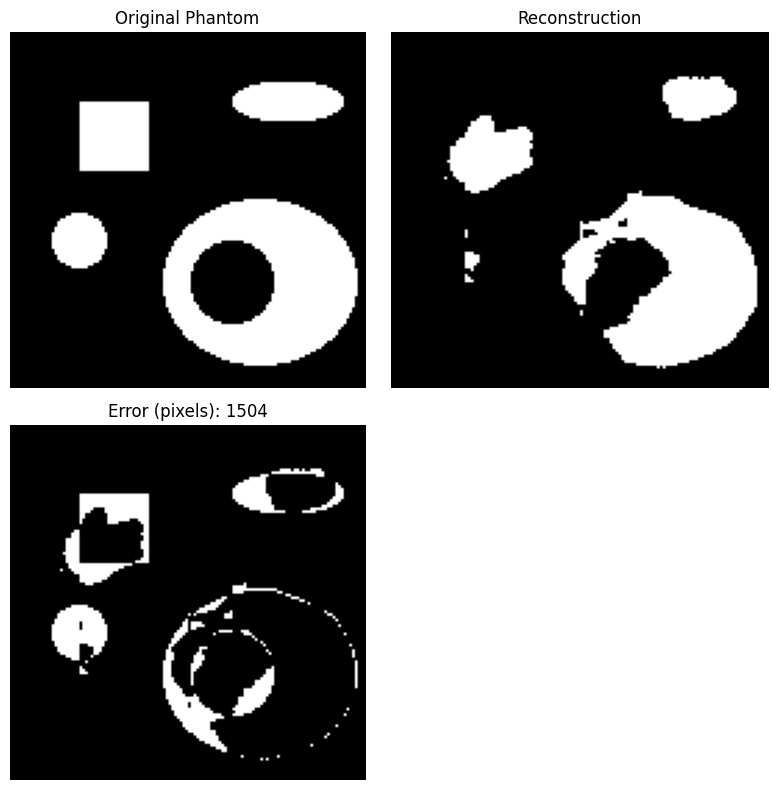

e1, e2, dice, jaccard: 0 0.8845479589281242 0.6384111384104848 0.46887218045112783


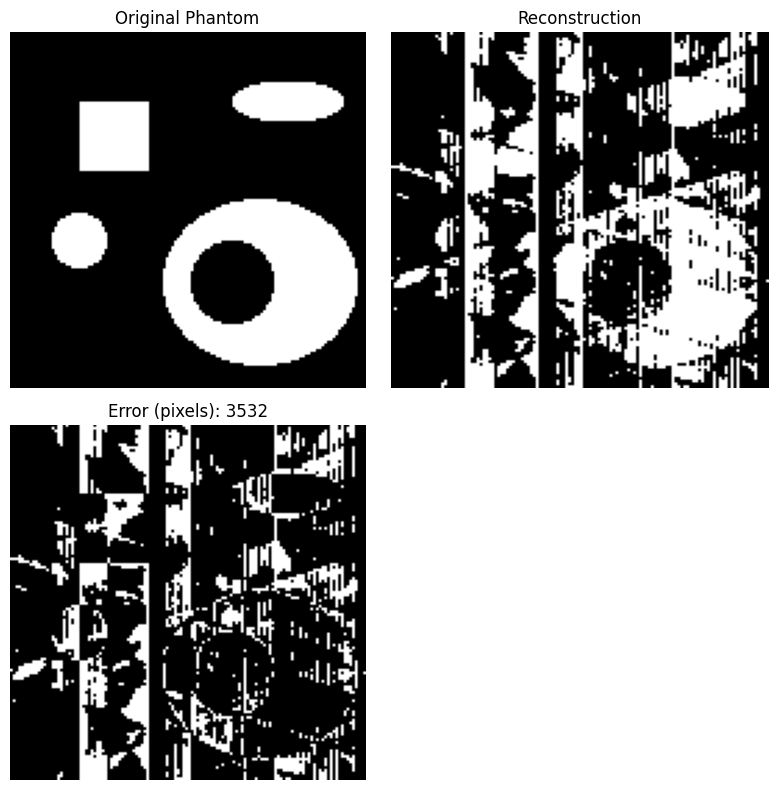

In [ ]:
# Parameters
N = 128
img = Image.open('/content/ph2.png')
img = img.resize((N, N))
phantom = np.array(img).astype(np.uint8)
M = int(2 ** np.ceil(np.log2(N * np.sqrt(2))))
angles =np.linspace(0, np.pi, 6)
#angles = np.random.rand(20)*np.pi

# Create geometries
vol_geom = astra.create_vol_geom(N, N)
proj_geom = astra.create_proj_geom('parallel', 1.0, M, angles)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

# Generate sinogram using ASTRA
phantom_id = astra.data2d.create('-vol', vol_geom, phantom)
sinogram_id, sinogram = astra.create_sino(phantom_id, proj_id)
sinogram += np.random.normal(loc=0, scale=1.5, size=sinogram.shape)
sinogram = np.maximum(sinogram, 0)

# ART reconstruction (via ASTRA)
rec_id = astra.data2d.create('-vol', vol_geom, 0)
cfg = astra.astra_dict('SART')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 20)
rec_art = astra.data2d.get(rec_id)

astra.algorithm.delete(alg_id)

# Custom FBP-like reconstruction using system matrix
cfg = astra.astra_dict('FBP')
cfg['ProjectorId'] = proj_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ReconstructionDataId'] = rec_id
cfg['FilterType'] = 'shepp-logan'
fbp_id = astra.algorithm.create(cfg)
astra.algorithm.run(fbp_id)
rec_fbp = astra.data2d.get(rec_id)

astra.data2d.delete(rec_id)
astra.algorithm.delete(alg_id)

# Extract W
matrix_id = astra.projector.matrix(proj_id)
W = astra.matrix.get(matrix_id)
astra.matrix.delete(matrix_id)


# Clean up ASTRA memory
astra.data2d.delete(sinogram_id)
astra.data2d.delete(phantom_id)
astra.projector.delete(proj_id)
astra.matrix.delete(matrix_id)

# Return relevant data for further use
result = {
    "phantom": phantom,
    "sinogram": sinogram,
    "rec_art": rec_art,
    "rec_fbp": rec_fbp,
    "system_matrix": W,
}

def plot_reconstruction_grid(phantom, reconstruction, loss=[]):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    plt.gray()

    # Original Phantom
    axes[0, 0].imshow(phantom)
    axes[0, 0].set_title('Original Phantom')

    # Reconstruction
    axes[0, 1].imshow(reconstruction, aspect='auto')
    axes[0, 1].set_title('Reconstruction')

    # Error Map
    error_map = np.where(phantom != reconstruction, 1, 0)
    error_count = np.sum(error_map)
    axes[1, 0].imshow(error_map)
    axes[1, 0].set_title(f'Error (pixels): {error_count}')

    reconstruction = reconstruction.ravel()
    phantom = phantom.ravel()

    #e1 = np.linalg.norm(result["system_matrix"] @ reconstruction - phantom)
    e2 = np.sum(np.abs(reconstruction - phantom)) / np.sum(phantom)
    dice = 2 * np.sum(reconstruction * phantom) / (np.sum(reconstruction) + np.sum(phantom) + 1e-8)
    jaccard = jaccard_score(phantom, reconstruction)
    print("e1, e2, dice, jaccard:", 0, e2, dice, jaccard)

    if len(loss) > 0:
        axes[1, 1].plot(loss)
        axes[1, 1].set_title('Loss Curve')
        axes[1, 1].set_xlabel('Iteration')
        axes[1, 1].set_ylabel('Loss')
    else:
        axes[1, 1].axis('off')

    for ax in axes.ravel():
        ax.axis('off' if ax.get_title() not in ['Loss Curve'] else 'on')

    plt.tight_layout()
    plt.show()


plot_reconstruction_grid(
    result["phantom"],
    np.where(result["rec_art"]>0.5, 1, 0)
)
plot_reconstruction_grid(
    result["phantom"],
    np.where(result["rec_fbp"]>0.5, 1, 0)
)

4068
[0 0 0 ... 0 0 0]
Initial error: 205.044896
[0] Improved error: 205.017921
[2] Improved error: 204.741385
[7] Improved error: 204.706188
[8] Improved error: 204.567123
[10] Improved error: 204.390454
[12] Improved error: 204.305588
[14] Improved error: 204.178398
[15] Improved error: 204.023127
[18] Improved error: 204.009932
[20] Improved error: 203.961856
[21] Improved error: 203.728128
[22] Improved error: 203.655573
[23] Improved error: 203.547176
[26] Improved error: 203.345326
[28] Improved error: 203.121136
[31] Improved error: 203.039008
[32] Improved error: 202.854079
[33] Improved error: 202.617261
[34] Improved error: 202.602124
[35] Improved error: 202.528593
[36] Improved error: 202.365964
[37] Improved error: 202.357434
[38] Improved error: 202.221384
[39] Improved error: 202.136605
[42] Improved error: 202.117245
[45] Improved error: 202.043499
[47] Improved error: 202.013792
[49] Improved error: 201.797808
[51] Improved error: 201.783087
[52] Improved error: 201.67

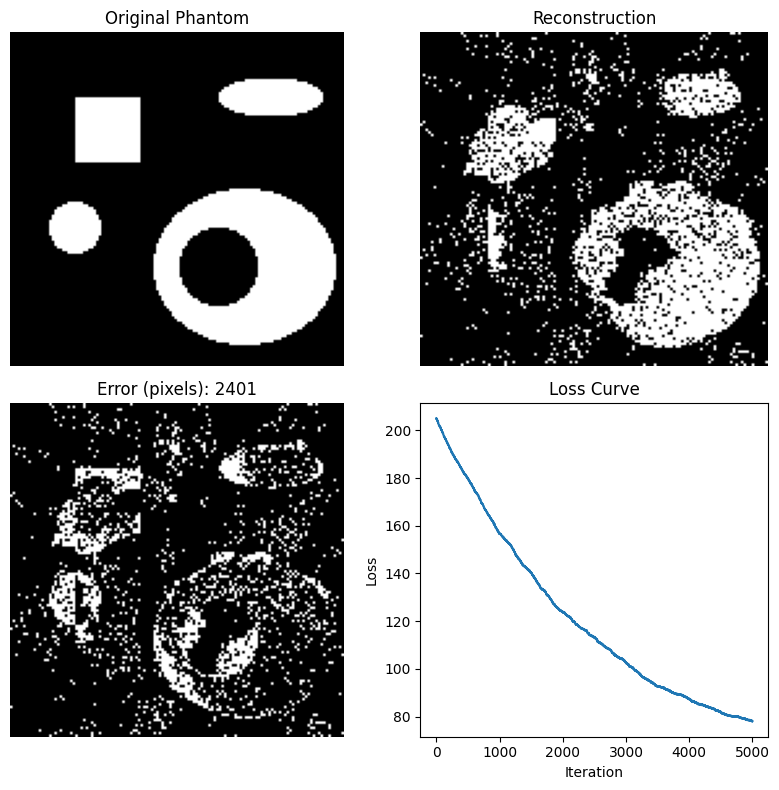

e1, e2, dice, jaccard: 0 73.69070874029552 0.7031771541591011 0.5422306959008579


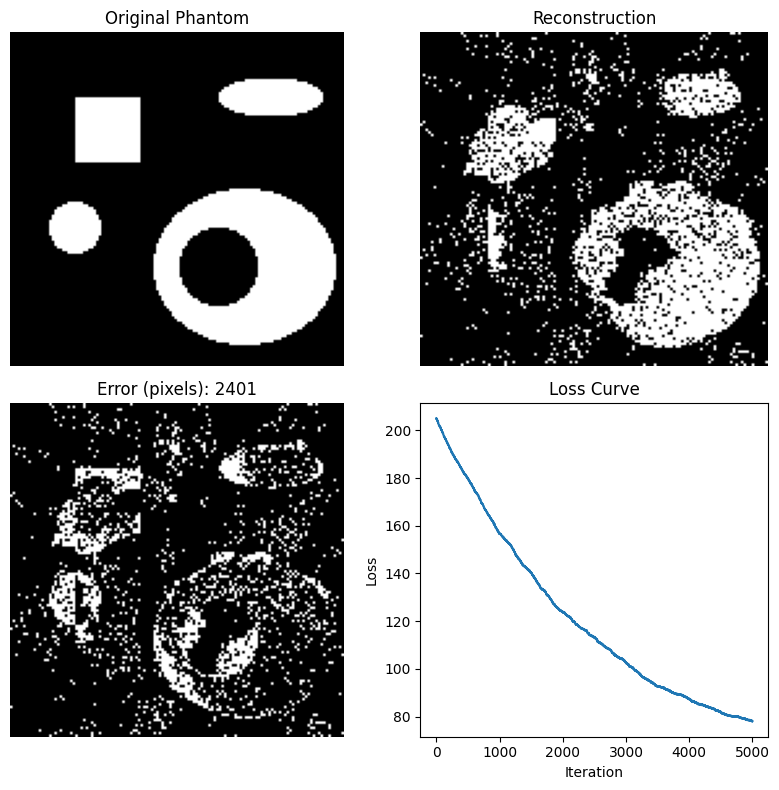

In [18]:
threshold = 0.5
max_iter = 5000
epsilon = 0.0005
verbose = True

W = result["system_matrix"]
sinogram = result["sinogram"]
sino_target = sinogram.ravel()
X_init = result["rec_art"].ravel()
#Estimate area from sinograms
A = int(np.round(sum(sino_target)/len(angles)))
print(A)
# take A most shiny pixels
X = np.zeros_like(X_init, dtype=np.uint8)
X[np.argsort(X_init)[-A:]] = 1
print(X)

# L2, L1 whatever we want
def proj_error(x_bin):
    return np.linalg.norm(W @ x_bin - sino_target, ord=2)

best_err = proj_error(X)
loss_history = [best_err] # To store loss values for plotting

print(f"Initial error: {best_err:.6f}")

# --- Binary Tomography Refinement Loop (Greedy Local Search) ---
for iteration in range(max_iter):
    idx = np.random.randint(5, N * N) # Choose a random pixel index
    X[idx] = 1 - X[idx]  # Flip the pixel (0 to 1, or 1 to 0)

    current_proj_error = np.linalg.norm(W @ X - sino_target)
    loss_history.append(current_proj_error) # Store improved loss
    if current_proj_error < best_err:
        best_err = current_proj_error
        if verbose:
            print(f"[{iteration}] Improved error: {best_err:.6f}")
        if best_err < epsilon:
            if verbose:
                print(f"Reached desired error < {epsilon} at iteration {iteration}")
            break # Stop if error is below epsilon
    else:
        X[idx] = 1 - X[idx]  # Revert the flip if it didn't improve the error

# Reshape the best binary image back to its original N x N dimensions
refined = X.reshape(N, N)

plot_reconstruction_grid(phantom, refined, loss_history)

plot_reconstruction_grid(
    phantom,
    refined,
    loss_history
)


Pass 1: 852 pixels updated
Pass 2: 867 pixels updated
Pass 3: 864 pixels updated
e1, e2, dice, jaccard: 0 71.34385174054596 0.7259894126534837 0.5698456667985754


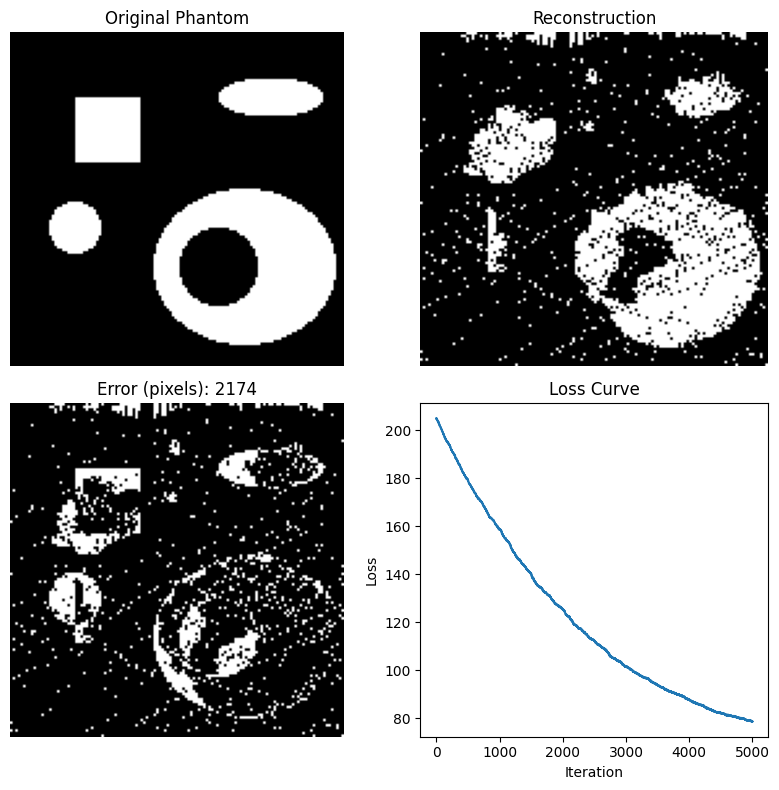

In [4]:
# --- Projection-by-projection binary refinement ---
X_init = rec_art.ravel()
A = int(np.round(sum(sino_target)/len(angles)))
X_bin = np.zeros_like(X_init, dtype=np.uint8)
X_bin[np.argsort(X_init)[-A:]] = 1
num_projs = W.shape[0]
epsilon_rel = 0.01  # 5% relative tolerance
max_passes = 3

num_projs = W.shape[0]
all_projection_indices = np.arange(num_projs)

for pass_idx in range(max_passes):
    changes = 0

    np.random.shuffle(all_projection_indices)

    for i in all_projection_indices:
        row = W.getrow(i)
        p_real = sino_target[i]
        p_sim = row @ X_bin
        diff = p_sim.item() - p_real

        if abs(diff) <= epsilon_rel * (abs(p_real) + 1e-8):
            continue  # already within tolerance

        # Pixels involved in this projection
        involved_pixels = row.indices
        if len(involved_pixels) == 0:
            continue  # skip empty rows

        if diff > 0:
            candidates = [j for j in involved_pixels if X_bin[j] == 1]
        else:
            candidates = [j for j in involved_pixels if X_bin[j] == 0]

        if len(candidates) == 0:
            continue

        # Greedy pick: one that reduces error the most
        best_j = None
        best_err = abs(diff)
        original_proj = p_sim.item()

        for j in candidates:
            X_bin[j] = 1 - X_bin[j]  # flip
            new_proj = row @ X_bin
            new_err = abs(new_proj.item() - p_real)
            if new_err < best_err:
                best_j = j
                best_err = new_err
            X_bin[j] = 1 - X_bin[j]  # revert

        if best_j is not None and best_err < abs(diff):
            X_bin[best_j] = 1 - X_bin[best_j]
            changes += 1

    print(f"Pass {pass_idx+1}: {changes} pixels updated")
    if changes == 0:
        break  # converged

# Final image
refined = X_bin.reshape(N, N)

# Visualization
plot_reconstruction_grid(
    phantom,
    refined,
    loss_history
)


e1, e2, dice, jaccard: 0 123.045830202855 0.6612284069087313 0.4939068100358423


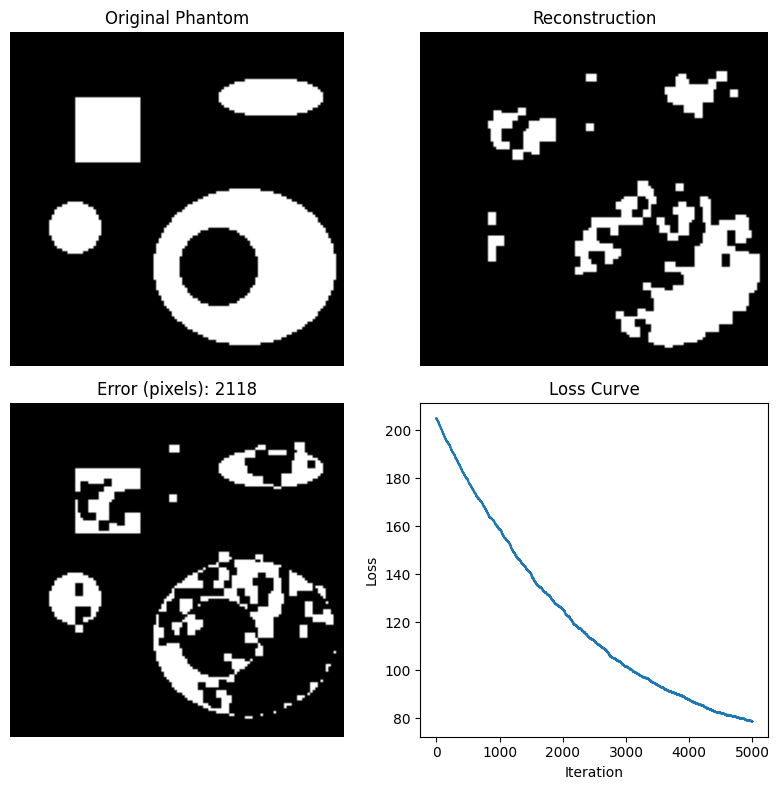

In [5]:
from scipy import ndimage
refined = X.reshape(N, N)
morph_structure_size = 3
morph_structure = np.ones((morph_structure_size, morph_structure_size), dtype=bool) # 3x3 square
refined = ndimage.binary_opening(refined, structure=morph_structure, iterations=1)


plot_reconstruction_grid(phantom, refined, loss_history)

Initial A (number of 'on' pixels to target): 3281
Initial error: 256.240188
[1] Improved error: 256.193236
[2] Improved error: 256.099139
[3] Improved error: 255.832457
[4] Improved error: 255.667722
[6] Improved error: 255.600215
[7] Improved error: 255.557524
[8] Improved error: 255.259088
[9] Improved error: 255.216753
[11] Improved error: 255.209989
[12] Improved error: 254.937272
[13] Improved error: 254.716007
[16] Improved error: 254.604557
[20] Improved error: 254.320783
[24] Improved error: 254.181380
[27] Improved error: 253.915602
[28] Improved error: 253.884888
[30] Improved error: 253.794396
[34] Improved error: 253.467364
[37] Improved error: 253.377327
[39] Improved error: 253.376335
[40] Improved error: 253.188558
[42] Improved error: 252.945596
[46] Improved error: 252.859158
[52] Improved error: 252.750423
[54] Improved error: 252.501591
[59] Improved error: 252.459014
[61] Improved error: 252.261095
[63] Improved error: 252.035742
[64] Improved error: 251.990963
[68]

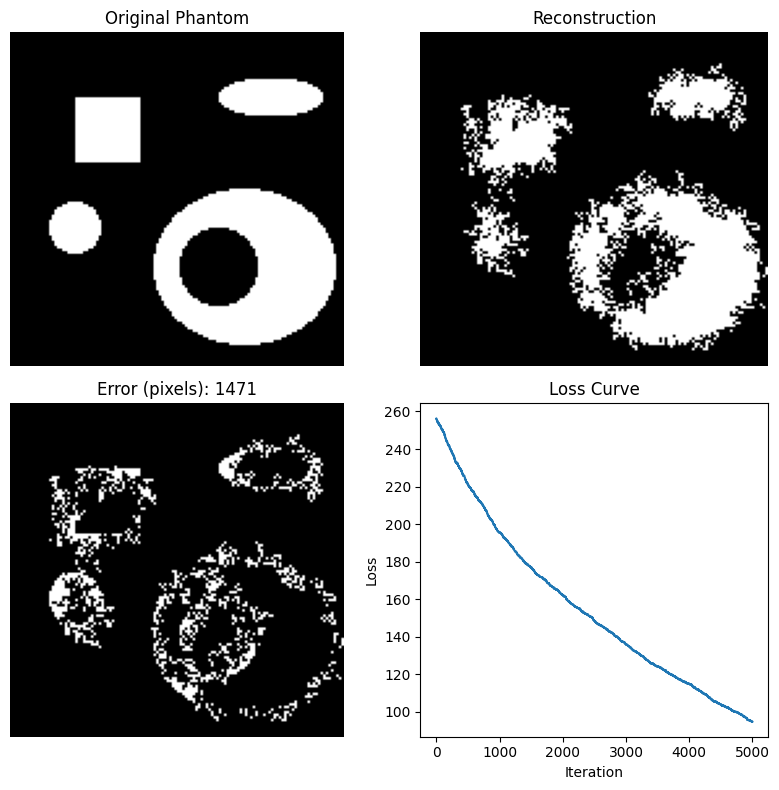

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.ndimage import median_filter, binary_opening, generate_binary_structure


threshold = 0.5
max_iter = 5000
epsilon = 0.005
verbose = True # Set to True to see iteration updates

sinogram = result["sinogram"]
sino_target = sinogram.ravel()
X_init = rec_art.ravel()

# Calculate 'A' based on the FBP image, representing the approximate number of 'on' pixels
# This is a critical step for initializing X
A = int(np.round(np.sum(X_init > threshold))) # Count pixels above threshold in FBP as 'on'
print(f"Initial A (number of 'on' pixels to target): {A}")


# Define sampling distribution from FBP (still useful as a fallback or for initial sampling bias)
fbp_flat = rec_art.ravel().astype(np.float64)
uncertainty = 1.0 - np.abs(fbp_flat - 0.5) * 2  # maps [0,1] to [1,0], max at 0.5
uncertainty = np.clip(uncertainty, 0, 1) + 1e-6
prob_weights = uncertainty / uncertainty.sum()



X = np.zeros_like(X_init, dtype=np.uint8)
# Initialize X by setting the 'A' brightest pixels from FBP to 1
# This gives a better starting point than random or all zeros.
X[np.argsort(X_init)[-A:]] = 1

def proj_error(x_bin):
    """Calculates the L2 norm of the difference between actual and synthetic sinogram."""
    return np.linalg.norm(W @ x_bin - sino_target)

best_X = X.copy()
best_err = proj_error(X)
loss_history = [best_err] # To store loss values for plotting

print(f"Initial error: {best_err:.6f}")

# --- Binary Tomography Refinement Loop (Greedy Local Search with Boundary Sampling) ---
boundary_recalc_freq = 100 # Recalculate boundary pixels every N iterations
current_boundary_indices = []

for iteration in range(max_iter):

    # Periodically update boundary pixels
    if iteration % boundary_recalc_freq == 0:
        X_2d = X.reshape(N, N)

        # Efficient boundary detection using scipy.ndimage
        # A pixel is on the boundary if its value is different from any of its neighbors.
        # This can be found by (dilated_image XOR eroded_image)
        # Using a 3x3 square structuring element for 8-connectivity check
        selem = np.ones((3, 3), dtype=bool)

        eroded_X = binary_erosion(X_2d, structure=selem)
        dilated_X = binary_dilation(X_2d, structure=selem)

        # Pixels that are different in erosion or dilation are boundary candidates
        boundary_mask = (X_2d != eroded_X) | (X_2d != dilated_X)

        temp_boundary_indices = np.where(boundary_mask.ravel())[0].tolist()

        if len(temp_boundary_indices) > 0:
            current_boundary_indices = temp_boundary_indices
        else:
            # Fallback: if no clear boundary (e.g., image is all 0s or all 1s),
            # revert to FBP-weighted sampling or all pixels
            current_boundary_indices = np.random.choice(len(X), p=prob_weights, size=int(len(X)*0.1)).tolist() # sample 10% randomly
            if verbose:
                print(f"[{iteration}] No clear boundary found, falling back to random FBP-weighted sampling for this phase.")


    if len(current_boundary_indices) > 0:
        idx = np.random.choice(current_boundary_indices)
    else:
        # Should be covered by the fallback above, but as a safeguard
        idx = np.random.choice(len(X), p=prob_weights) # Fallback to FBP weights if somehow empty


    X[idx] = 1 - X[idx]  # Flip the pixel (0 to 1, or 1 to 0)

    # Calculate error for the flipped image.
    current_proj_error = proj_error(X) # Use the defined function for clarity
    loss_history.append(current_proj_error) # Store improved loss
    if current_proj_error < best_err:
        best_err = current_proj_error
        if verbose:
            print(f"[{iteration}] Improved error: {best_err:.6f}")
        if best_err < epsilon:
            if verbose:
                print(f"Reached desired error < {epsilon} at iteration {iteration}")
            break # Stop if error is below epsilon
    else:
        X[idx] = 1 - X[idx]  # Revert the flip if it didn't improve the error


# Reshape the best binary image back to its original N x N dimensions
refined = X.reshape(N, N)

# Visualization
plot_reconstruction_grid(
    phantom,
    refined,
    loss_history
)

Initial A (number of 'on' pixels to target): 3281
Initial total loss: 1108.720188
[8] Improved total loss: 1108.525554
[14] Improved total loss: 1106.186992
[18] Improved total loss: 1103.999370
[28] Improved total loss: 1103.762943
[35] Improved total loss: 1101.246360
[36] Improved total loss: 1101.174187
[56] Improved total loss: 1100.901189
[63] Improved total loss: 1100.835132
[71] Improved total loss: 1098.309859
[77] Improved total loss: 1098.215593
[79] Improved total loss: 1097.962772
[80] Improved total loss: 1097.679711
[93] Improved total loss: 1097.464694
[96] Improved total loss: 1097.292722
[99] Improved total loss: 1097.248017
[100] Improved total loss: 1097.127473
[111] Improved total loss: 1097.012577
[127] Improved total loss: 1096.985675
[129] Improved total loss: 1096.904033
[130] Improved total loss: 1096.881945
[137] Improved total loss: 1094.317086
[152] Improved total loss: 1094.306099
[165] Improved total loss: 1094.218900
[189] Improved total loss: 1094.15402

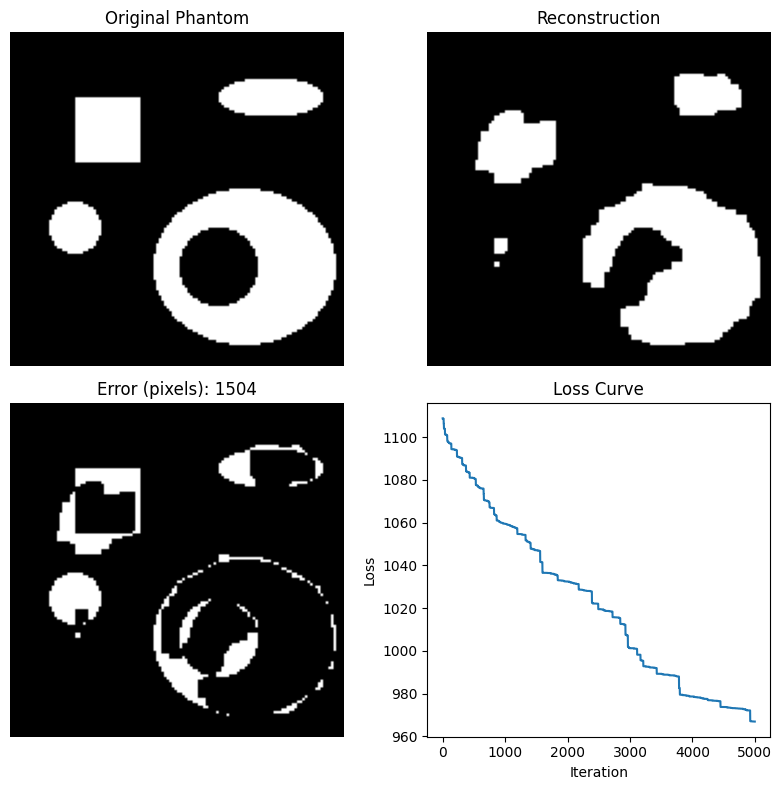

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation, median_filter
from scipy.ndimage import convolve

# --- PARAMETERS ---
threshold = 0.5
max_iter = 5000
# --- INITIALIZATION ---
sinogram = result["sinogram"]
sino_target = sinogram.ravel()

X_init = result['rec_art'].ravel()

A = int(np.round(np.sum(X_init > threshold)))
print(f"Initial A (number of 'on' pixels to target): {A}")

fbp_flat = rec_fbp.ravel().astype(np.float64)
uncertainty = 1.0 - np.abs(fbp_flat - 0.5) * 2  # maps [0,1] to [1,0], max at 0.5
uncertainty = np.clip(uncertainty, 0, 1) + 1e-6
prob_weights = uncertainty / uncertainty.sum()


X = np.zeros_like(X_init, dtype=np.uint8)
X[np.argsort(X_init)[-A:]] = 1

# --- ERROR + REGULARIZATION ---
def proj_error(x_bin):
    return np.linalg.norm(W @ x_bin - sino_target)

def total_variation(x_bin):
    x_2d = x_bin.reshape(N, N)
    gx = np.abs(np.diff(x_2d, axis=1)).sum()
    gy = np.abs(np.diff(x_2d, axis=0)).sum()
    return gx + gy

def total_loss(x_bin):
    return proj_error(x_bin) + lambda_tv * total_variation(x_bin)

# --- MAIN OPTIMIZATION ---
lambda_tv = 0.01
best_X = X.copy()
best_err = total_loss(X)
loss_history = [best_err]
print(f"Initial total loss: {best_err:.6f}")

current_boundary_indices = []

for iteration in range(max_iter):
    if iteration % boundary_recalc_freq == 0:
        X_2d = X.reshape(N, N)
        selem = np.ones((3, 3), dtype=bool)
        eroded = binary_erosion(X_2d, structure=selem)
        dilated = binary_dilation(X_2d, structure=selem)
        boundary_mask = (X_2d != eroded) | (X_2d != dilated)
        temp_boundary_indices = np.where(boundary_mask.ravel())[0].tolist()

        if len(temp_boundary_indices) > 0:
            current_boundary_indices = temp_boundary_indices
        else:
            current_boundary_indices = np.random.choice(len(X), p=prob_weights, size=int(len(X)*0.1)).tolist()
            if verbose:
                print(f"[{iteration}] No boundary found, using fallback sampling.")

    idx = np.random.choice(current_boundary_indices)
    X[idx] = 1 - X[idx]
    current_loss = total_loss(X)
    loss_history.append(best_err)

    if current_loss < best_err:
        best_err = current_loss
        best_X = X.copy()
        if verbose:
            print(f"[{iteration}] Improved total loss: {best_err:.6f}")
        if best_err < epsilon:
            print(f"Reached epsilon threshold at iteration {iteration}")
            break
    else:
        X[idx] = 1 - X[idx]  # revert

refined = X.reshape(N, N)

plot_reconstruction_grid(
    phantom,
    refined,
    loss_history
)


e1, e2, dice, jaccard: 0 61.76058101677936 0.8014822657480128 0.6687279151943463


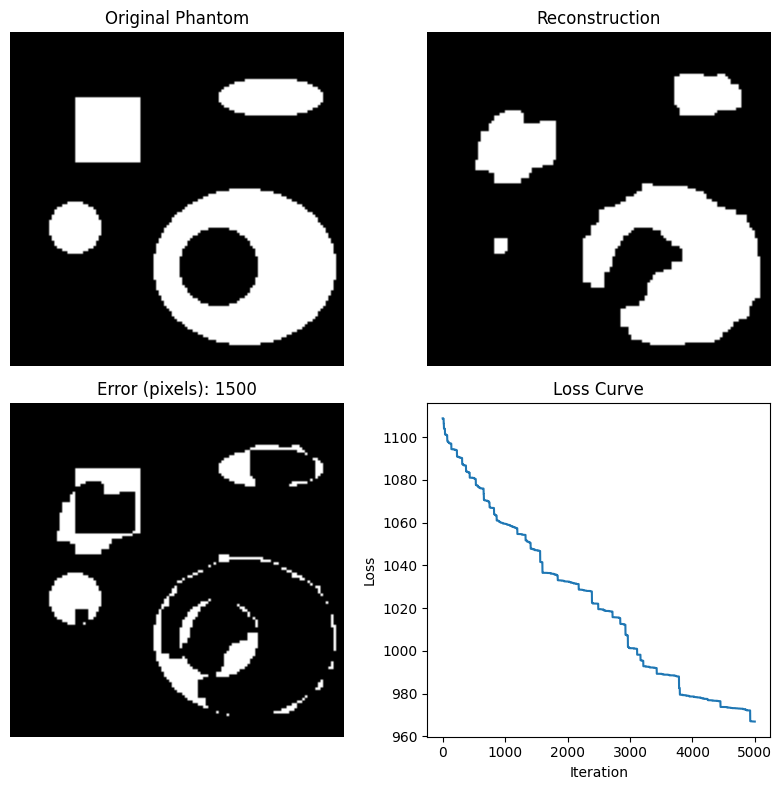

In [8]:
from scipy import ndimage
refined = best_X.reshape(N, N)
morph_structure_size = 3
morph_structure = np.ones((morph_structure_size, morph_structure_size), dtype=bool) # 3x3 square
refined = ndimage.binary_opening(refined, structure=morph_structure, iterations=1)
refined = ndimage.binary_closing(refined, structure=morph_structure, iterations=1)

plot_reconstruction_grid(phantom, refined, loss_history)

Initial A (number of 'on' pixels to target): 3281
Initial total loss: 289.540187
[4] Improved total loss: 289.503308
[6] Improved total loss: 289.198650
[11] Improved total loss: 289.064573
[14] Improved total loss: 288.967869
[21] Improved total loss: 288.952138
[22] Improved total loss: 288.885274
[23] Improved total loss: 288.780553
[26] Improved total loss: 288.739629
[27] Improved total loss: 288.536773
[30] Improved total loss: 288.496477
[31] Improved total loss: 288.432287
[34] Improved total loss: 288.237413
[38] Improved total loss: 287.959760
[42] Improved total loss: 287.877475
[44] Improved total loss: 287.705047
[45] Improved total loss: 287.687832
[47] Improved total loss: 287.684723
[52] Improved total loss: 287.635193
[53] Improved total loss: 287.509588
[55] Improved total loss: 287.344267
[59] Improved total loss: 287.325509
[62] Improved total loss: 287.242915
[63] Improved total loss: 287.094091
[64] Improved total loss: 286.903406
[67] Improved total loss: 286.874

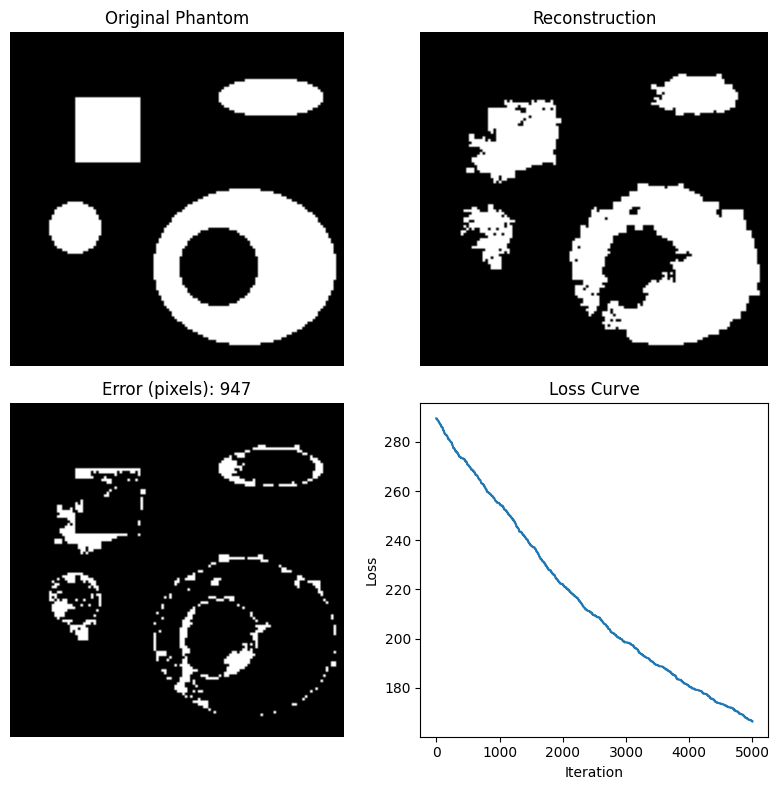

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation, distance_transform_edt

# --- PARAMETERS ---
threshold = 0.5
fixed_pixels_per_iter = 10
max_iter = 5000
boundary_recalc_freq = 100
epsilon = 1e-3
verbose = True
lambda_tv = 0.05

# --- INITIALIZATION ---
sinogram = result["sinogram"]
sino_target = sinogram.ravel()
X_init = result['rec_art'].ravel()
A = int(np.round(np.sum(X_init > threshold)))
print(f"Initial A (number of 'on' pixels to target): {A}")

fbp_flat = rec_fbp.ravel().astype(np.float64)
uncertainty = 1.0 - np.abs(fbp_flat - 0.5) * 2
uncertainty = np.clip(uncertainty, 0, 1) + 1e-6
prob_weights = uncertainty / uncertainty.sum()

X = np.zeros_like(X_init, dtype=np.uint8)
X[np.argsort(X_init)[-A:]] = 1
fixed_mask = np.zeros_like(X, dtype=bool)

# --- ERROR + REGULARIZATION ---
def proj_error(x_bin):
    return np.linalg.norm(W @ x_bin - sino_target)

from scipy.ndimage import convolve

def total_variation(x_bin):
    x_2d = x_bin.reshape(N, N).astype(np.float32)
    kernel = np.array([[1, -1]])
    tv_x = np.abs(convolve(x_2d, kernel, mode='constant')).sum()
    tv_y = np.abs(convolve(x_2d, kernel.T, mode='constant')).sum()
    return tv_x + tv_y

def total_loss(x_bin):
    return proj_error(x_bin) + lambda_tv * total_variation(x_bin)

# --- MAIN OPTIMIZATION ---
best_X = X.copy()
best_err = total_loss(X)
loss_history = [best_err]
print(f"Initial total loss: {best_err:.6f}")

current_boundary_indices = []

for iteration in range(max_iter):
    if iteration % boundary_recalc_freq == 0:
        X_2d = X.reshape(N, N)
        selem = np.ones((3, 3), dtype=bool)
        eroded = binary_erosion(X_2d, structure=selem)
        dilated = binary_dilation(X_2d, structure=selem)
        boundary_mask = (X_2d != eroded) | (X_2d != dilated)
        temp_boundary_indices = np.where(boundary_mask.ravel())[0].tolist()

        if temp_boundary_indices:
            current_boundary_indices = temp_boundary_indices
        else:
            current_boundary_indices = np.random.choice(
                len(X), p=prob_weights, size=int(len(X) * 0.1)
            ).tolist()
            if verbose:
                print(f"[{iteration}] No boundary found, using fallback sampling.")

        # --- Fix high-distance pixels cumulatively ---
        X_2d = X.reshape(N, N)
        dt = distance_transform_edt(1 - X_2d)
        dt_flat = dt.ravel()
        candidate_idxs = np.argsort(-dt_flat)
        added = 0
        for i in candidate_idxs:
            if not fixed_mask[i] and X[i] == 1:
                fixed_mask[i] = True
                added += 1
            if added >= fixed_pixels_per_iter:
                break

    current_boundary_indices = [i for i in current_boundary_indices if not fixed_mask[i]]
    if not current_boundary_indices:
        continue

    idx = np.random.choice(current_boundary_indices)
    X[idx] = 1 - X[idx]
    current_loss = total_loss(X)

    if current_loss < best_err:
        best_err = current_loss
        best_X = X.copy()
        if verbose:
            print(f"[{iteration}] Improved total loss: {best_err:.6f}")
        loss_history.append(best_err)


        if best_err < epsilon:
            print(f"Reached epsilon threshold at iteration {iteration}")
            break
    else:
        X[idx] = 1 - X[idx]  # revert
        loss_history.append(best_err)

# --- FINAL OUTPUT ---
refined = best_X.reshape(N, N)
plot_reconstruction_grid(phantom, refined, loss_history)
